In [18]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from CL_utilities.ContrastiveGenerator import ContrastiveGenerator
from distance.CL_Euclidean_Distance import CL_Euclidean_Distance
from CL_utilities.CL_mapping import Generate_pack_of_images
from CL_utilities import CL_visualization
from CL_utilities import CL_loss


In [19]:
#HYPERPARAMETERS

epochs = 10
batch_size = 8
margin = 1 # margin for contrastive loss

In [20]:
path = r"/home/c100rczyk/VSCode/InsERT/Fruits"
# path = r"C:\Users\matim\Documents\Fruits360\archive\fruits-360_dataset\fruits-360\Training"
# path = r"C:\Users\matim\Documents\FruitDataset\archive"

number_of_pairs = 32    # WE Create number_of_pairs * 2  pairs.
generator = ContrastiveGenerator(path, number_of_pairs)

27


# Generator for creating dataset

In [21]:
dataset = tf.data.Dataset.from_generator( generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.float32)))

# Create new pack of images and label

In [22]:
IMAGE_SIZE = (258, 320)

pack_of_images = Generate_pack_of_images(IMAGE_SIZE, batch_size)
img_pack = dataset.map( lambda image_path1, image_path2, value: (pack_of_images(image_path1, image_path2, value))).batch(batch_size)
touple_of_products = img_pack

print(touple_of_products)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


# (1.) See Documentation to get info about structure of dataset

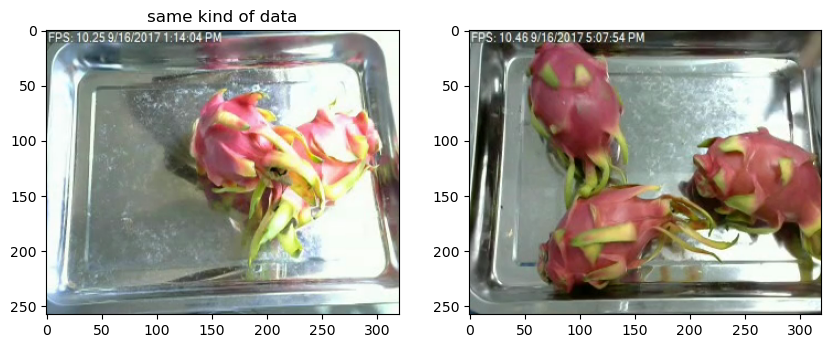

Etykieta: 0


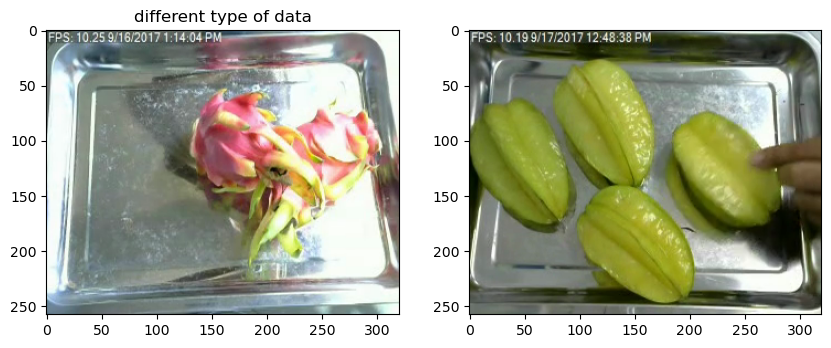

Etykieta: 1


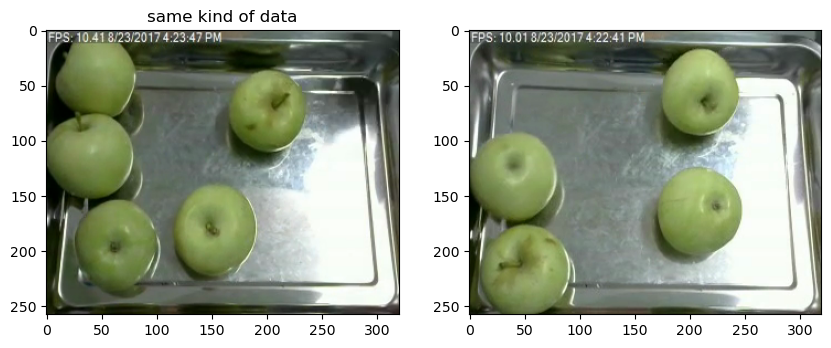

Etykieta: 0


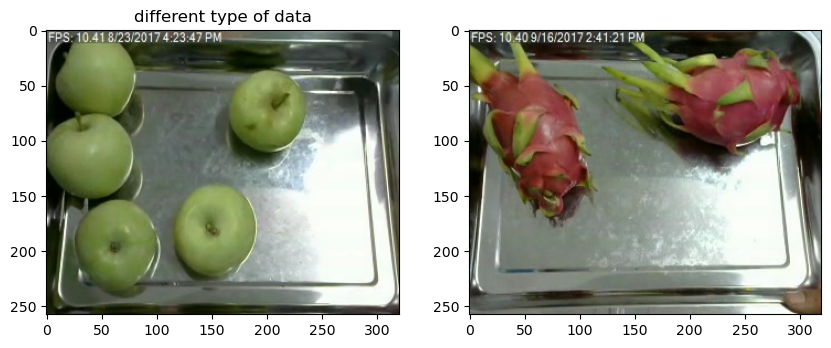

Etykieta: 1


2024-04-08 22:32:51.354189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
CL_visualization.visualize(touple_of_products)

In [24]:
import keras

input = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
embedding_network = keras.Model(input, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu


In [25]:
input_1 = keras.layers.Input((258,320,3))
input_2 = keras.layers.Input((258,320,3))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

euclidean_distance = CL_Euclidean_Distance()
merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [26]:
siamese.compile(loss=CL_loss.loss(margin=margin), optimizer='adam', metrics=['accuracy'])
siamese.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_13       │ (None, 16)        │ 19,830,556 │ input_layer_9[0]… │
│ (Functional)        │                   │            │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional_13[0]… │
│                     │                   │            │ functional_13[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,830,562 (75.65 MB)

 Trainable params: 19,830,426 (75.65 MB)

 Non-trainable params: 136 (544.00 B)

In [ ]:
# How many samples we have, and how many we want in train and validation
num_samples = sum(1 for _ in touple_of_products)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size
# .take() to get from actual batch
train_dataset = touple_of_products.take(train_size)
val_dataset = touple_of_products.skip(train_size)


Trained_model_data = siamese.fit(train_dataset, 
                                 validation_data= val_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/10


2024-04-08 22:32:57.480426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


      6/Unknown 6s 606ms/step - accuracy: 0.6014 - loss: 0.2432

2024-04-08 22:33:03.895876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 755ms/step - accuracy: 0.5899 - loss: 0.2404 - val_accuracy: 0.5000 - val_loss: 0.3327
Epoch 2/10


2024-04-08 22:33:04.606195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4448 - loss: 0.2645

2024-04-08 22:33:08.312904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 684ms/step - accuracy: 0.4497 - loss: 0.2578 - val_accuracy: 0.5000 - val_loss: 0.2410
Epoch 3/10


2024-04-08 22:33:08.671267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.5090 - loss: 0.2477

2024-04-08 22:33:12.310253: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 674ms/step - accuracy: 0.5018 - loss: 0.2438 - val_accuracy: 0.4375 - val_loss: 0.1675
Epoch 4/10


2024-04-08 22:33:12.674885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.4181 - loss: 0.2662

2024-04-08 22:33:16.395518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 684ms/step - accuracy: 0.4179 - loss: 0.2608 - val_accuracy: 0.6250 - val_loss: 0.1714
Epoch 5/10


2024-04-08 22:33:16.749365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6087 - loss: 0.2324

2024-04-08 22:33:20.422517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 677ms/step - accuracy: 0.5872 - loss: 0.2304 - val_accuracy: 0.5000 - val_loss: 0.2404
Epoch 6/10


2024-04-08 22:33:20.764116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.2969 - loss: 0.2930

2024-04-08 22:33:24.476149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 684ms/step - accuracy: 0.3080 - loss: 0.2852 - val_accuracy: 0.5000 - val_loss: 0.2114
Epoch 7/10


2024-04-08 22:33:24.842255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.5257 - loss: 0.2670

2024-04-08 22:33:28.590946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 701ms/step - accuracy: 0.5310 - loss: 0.2605 - val_accuracy: 0.4375 - val_loss: 0.2108
Epoch 8/10


2024-04-08 22:33:28.994383: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.4108 - loss: 0.2593

2024-04-08 22:33:32.755525: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
